## Tensorboard

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
np.random.seed(7777)
tf.random.set_seed(7777)

In [3]:
class Cifar10DataLoader():
    
    def __init__(self):
        (self.train_x, self.train_y),(self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()
        self.input_shape = self.train_x.shape[1:]
    
    def scale(self, x):
        return (x / 255.0).astype(np.float32)
    
    def preprocess_dataset(self, dataset):
        feature, target = dataset
        
        # scale
        scaled_x = np.array([self.scale(x) for x in feature])
    
        # label encoding
        ohe_y = np.array([tf.keras.utils.to_categorical(y, num_classes=10) for y in target])
        
        return scaled_x, ohe_y.squeeze(1)
    
    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))
    
    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))
    
cifar10_loader = Cifar10DataLoader()
train_x, train_y = cifar10_loader.get_train_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

test_x, test_y = cifar10_loader.get_test_dataset()

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(50000, 10) float32
(10000, 32, 32, 3) float32
(10000, 10) float32


In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

def build_resnet(input_shape):
    inputs = Input(input_shape)
    
    net = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
    net = MaxPool2D()(net)
    
    net1 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(net1) 
    net3 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(net2)
    
    net1_1 = Conv2D(32, kernel_size=1, padding='same')(net)
    net = Add()([net1_1, net3])
    
    net1 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(net1) 
    net3 = Conv2D(32, kernel_size=1, padding='same', activation='relu')(net2)
    
    net = Add()([net, net3])
    
    net = MaxPool2D()(net)
    
    net = Flatten()(net)
    net = Dense(10, activation='softmax')(net)
    
    model = tf.keras.Model(inputs=inputs, outputs=net, name ='resnet')
    
    return model

model= build_resnet((32,32,3))
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 32)     0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 32)     1056        ['max_pooling2d[0][0]']          
                                                                                             

### fit 함수로 학습 할 때는 callback 함수로 사용!

In [5]:
learning_rate = 0.03
opt = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [6]:
import datetime

cur_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [7]:
log_dir = 'logs/fit/' + cur_time

In [8]:
log_dir

'logs/fit/20230304-045301'

In [9]:
tb_callback=tf.keras.callbacks.TensorBoard(log_dir= log_dir)

In [10]:
model.fit(x = train_x, y=train_y, epochs=5, validation_data=(test_x, test_y), callbacks=[tb_callback])

C:\Users\kangminju\miniconda3\envs\ds_study\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
1563/1563 [==============================] - 35s 21ms/step - loss: 2.3351 - accuracy: 0.0990 - val_loss: 2.3581 - val_accuracy: 0.1000
Epoch 2/5
1563/1563 [==============================] - 29s 18ms/step - loss: 2.3415 - accuracy: 0.1016 - val_loss: 2.3160 - val_accuracy: 0.1000
Epoch 3/5
1563/1563 [==============================] - 31s 20ms/step - loss: 2.3394 - accuracy: 0.0964 - val_loss: 2.3228 - val_accuracy: 0.1000
Epoch 4/5
1563/1563 [==============================] - 33s 21ms/step - loss: 2.3436 - accuracy: 0.1001 - val_loss: 2.3383 - val_accuracy: 0.1000
Epoch 5/5
1563/1563 [==============================] - 33s 21ms/step - loss: 2.3446 - accuracy: 0.1007 - val_loss: 2.3189 - val_accuracy: 0.1000


In [22]:
!tensorboard --logdir logs/fit --bind_all

^C


### tf.summary 사용하기

In [11]:
loss_fn = tf.keras.losses.categorical_crossentropy

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(x,y):
    with tf.GradientTape() as tape:
        pred = model(x)
        loss = loss_fn(y, pred)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(y, pred)

@tf.function
def test_step(x,y):
    
    pred = model(x)
    loss = loss_fn(y, pred)
    
    test_loss = (loss)
    test_accuracy(y, pred)

In [12]:
train_log_dir = 'logs/grad_tape/train' + cur_time 
test_log_dir =  'logs/grad_tape/test' + cur_time 

In [13]:
train_writer = tf.summary.create_file_writer(train_log_dir)
test_writer = tf.summary.create_file_writer(test_log_dir)

In [14]:
batch_size = 64

num_train_batch = train_x.shape[0] // batch_size
num_test_batch = test_x.shape[0] // batch_size
for epoch in range(5):
    
    for i in range(num_train_batch):
        idx = i * batch_size
        x,y = train_x[idx:idx+batch_size], train_y[idx:idx+batch_size]
        
        train_step(x,y)
        print('train', i, end='\r')
        
    for i in range(num_test_batch):
        idx = i * batch_size
        x,y = test_x[idx:idx+batch_size], test_y[idx:idx+batch_size]
        
        test_step(x,y)
        print('test', i, end='\r') 
        
    with train_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('acc', train_accuracy.result(), step=epoch)
        
    with test_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('acc', test_accuracy.result(), step=epoch)
        
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

In [23]:
!tensorboard --logdir logs/grad_tape --bind_all 

^C


### Tensorboard에 이미지 데이터 기록

In [16]:
img = train_x[777]

In [17]:
img.shape

(32, 32, 3)

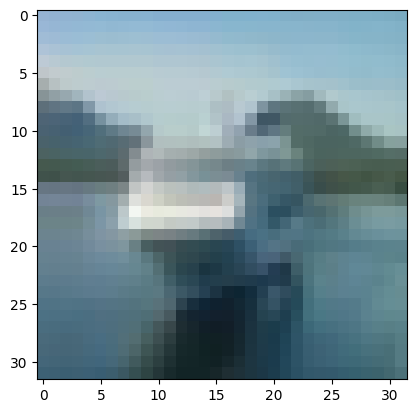

In [18]:
plt.imshow(img)
plt.show()

In [19]:
log_dir = 'logs.train_data/' + cur_time

In [20]:
log_dir

'logs.train_data/20230304-045301'

In [21]:
file_writer = tf.summary.create_file_writer(log_dir)

In [24]:
for i in np.random.randint(10000, size=10):
    img = train_x[i : i+1]
    with file_writer.as_default():
        tf.summary.image('Training sample {}'.format(i), img, step=0)

In [25]:
!tensorboard --logdir logs/train_data --bind_all 

^C


### LambdaCallback을 사용하여 Tensorboard에 Confusion Matrix 기록

In [32]:
import io
from sklearn.metrics import confusion_matrix

def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

def plot_confusion_matrix(cm, class_names):
    
    figure = plt.figure(figsize=(8,8))
    plt.imshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    threshold = cm.max() /2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = 'white' if cm[i, j] > threshold else 'black'
            plt.text(j, i, cm[i, j], horizontalalignment='center', color=color)
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

logdir = 'log/fit/cm/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
file_writer_cm = tf.summary.create_file_writer(logdir)

test_images = test_x[:100]
test_labels = np.argmax(test_y[:100], axis=1)

def log_confusion_matrix(epoch, logs):
    test_pred_raw = model.predict(test_images)
    test_pred = np.argmax(test_pred_raw, axis=1)
    
    classes = np.arange(10)
    cm = confusion_matrix(test_labels, test_pred, labels = classes)
    
    figure = plot_confusion_matrix(cm, class_names= classes)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image('Confusion Matrix', cm_image, step=epoch)

In [33]:
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end = log_confusion_matrix)

In [34]:
model.fit(x=train_x,y=train_y,epochs = 5,batch_size = 32,
          validation_data = (test_x, test_y),callbacks=[cm_callback])

Epoch 1/5
1563/1563 [==============================] - 22s 14ms/step - loss: 2.3144 - accuracy: 0.1001 - val_loss: 2.3097 - val_accuracy: 0.1000
Epoch 2/5
1563/1563 [==============================] - 22s 14ms/step - loss: 2.3318 - accuracy: 0.1004 - val_loss: 2.3293 - val_accuracy: 0.1000
Epoch 3/5
1563/1563 [==============================] - 23s 15ms/step - loss: 2.3421 - accuracy: 0.0988 - val_loss: 2.3382 - val_accuracy: 0.1000
Epoch 4/5
1563/1563 [==============================] - 23s 15ms/step - loss: 2.3384 - accuracy: 0.1010 - val_loss: 2.3116 - val_accuracy: 0.1000
Epoch 5/5
1563/1563 [==============================] - 20s 13ms/step - loss: 2.3223 - accuracy: 0.0997 - val_loss: 2.3305 - val_accuracy: 0.1000


In [37]:
!tensorboard --logdir logs/fit/cm

^C
